# WSI lab. 5 Sztuczne sieci neuronowe

Jakub Płudowski 300464, Tadeusz Golczyk 300531, Prowadzący ćwiczenia mgr. inż. Jakub Łyskawa

## Importing needed libraries

In [97]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## Defining personal parameters for the algorithm
The below variables are responsible for certain parameters:
- digits - imported dataset of pictures 8x8 pixels which represent numbers (MNIST datasets)
- n_samples - amount of pictures in MNIST dataset
- nr_of_parameters - number of connections from input neurons to hidden neurons
- nr_of_hidden_neurons - number of hidden neurons in network
- data - reshaped info about images, that are being formatted from 2-dimensional vectors [8x8] to 1-dimensional vectors [1x64]
- epochs - the amount of epochs that would be used to teach the network
- learning_rate - the step with which the weight of the neurons connections are being changed

In [98]:
digits = datasets.load_digits()
n_samples = len(digits.images)
nr_of_parameters = 64
nr_of_hidden_neurons = 32
data = digits.images.reshape((n_samples, -1))

np.random.seed(300464)
epochs = 10
learning_rate = 0.1

## Dividing dataset for learning, testing, and validating parts
Whole datasets are being divided for training dataset, which contains 90% of the possessed images, and validating and testing datasets which are being randomly chosen 10% of the original dataset.

In [99]:
input_train, input_test, output_train, output_test = train_test_split(
    data, digits.target, test_size=0.1, shuffle=True
)
input_train, input_vali, output_train, output_vali = train_test_split(
    input_train, output_train, test_size=0.1, shuffle=True
)

## Function used to evaluate the algorithm
In the algorithm, the 3 function are being used:
 - code_label(number) - this function is being used to translate the digits (which are being given by the argument "number") to the vector of 10 probabilities, which represent the probability that given number is being certain digit, so the function translate the digit for 100% probability of being this number, and 0% for being every other digit. This whole process is being used to easier compare results with output of the network, which are analogically - the probabilities for certain pictures to represent a certain digits.
 - activation(x) - the function of activation to calculate the value for the neurons in this network. In this certain network the function of activation is Sigmoid function.
 - dt_activation(array) - the derivative of the activation function.

In [100]:
def code_label(number):
    label = np.zeros((10))
    label[number] = 1
    return label

def activation(x):
    return 1/(1+ np.exp(-x))

def dt_activation(array):
    return [(np.exp(-x)/((np.exp(-x)+1)**2)) for x in array]

## Function to validate the network
This function is being used to compare the error (which is being calculated based on the verification dataset) of predicting the output of the network, which is being checked after every epoch, to the real values of the label of certain piece of dataset. The function get as an arguments the parameters of the nodes "parameters1", "parameters2" to  recreate the network, and the validation dataset "test_input" with validation labeles "test_output".

In [101]:
def validate_network(parameters1, parameters2, test_input, test_output):
    #assert len(test_input) == len(test_output)
    complex_error = np.ones(len(test_input))/len(test_input)
    #for test_idx, input_array in enumerate(test_input):
    for iteration in range(len(test_input)):
        input_array = test_input[iteration]
        hidden_stimulation = np.matmul(parameters1,input_array)
        hidden_output = [activation(x) for x in (hidden_stimulation)]
        output_stimulation = np.matmul(parameters2, hidden_output)
        output = [activation(x) for x in (output_stimulation)]
        
        complex_error[iteration] = np.mean(0.5*(np.subtract(code_label(test_output[iteration]), output)**2)/len(test_input))
        
    return np.sum(complex_error)

## Function to teach the network
The network is first randomizing a small value (around 1e-4) for the starting parameters. Then the network is being taught with every piece of the dataset, and repeated for every epoch. Teaching is being done by multiplying the started values (every value from the start vector from the dataset has a certain starting neuron) by the values of the weight of the parameters. These values are being used as input values for the activation function. Output from this function is added from every neuron that is entering the hidden neuron, and then the sum of this is the value of this neuron. The process is repeated afterward to obtain the output values of the neurons, which are later on interpreted as the probability of being element (in this case the possibility of the input picture to represent a certain number). The highest probability is being chosen, and this is the prediction of the network. The mean squared error of the prediction is being calculated later on based on the known value of the input from the label dataset. The value of the weights of the parameters are being afterward changed, based on the value of the error, so the error would be smaller in the next iteration.
After teaching, the plot of the error in each iteration and each epoch is being represented on the plot.
This function has the following arguments:
- nr_of_inputs - amount of the pieces in the learning dataset,
- nr_of_outputs - number of the outputs from the network,
- nr_of_hidden_neurons - number of the neurons in the hidden layer of the neurons,
- lr - step of changing of the value of the weight parameters between the neurons,
- nr_of_epochs - number of the epochs for teaching,
- train_input - dataset for learning,
- train_output - labels for dataset for learning,
- vali_input - dataset for validating,
- vali_output - labels for dataset for validating.

In [102]:
def train_network(nr_of_inputs, nr_of_outputs, nr_of_hidden_neurons, lr, nr_of_epochs, train_input, train_output, vali_input, vali_output):
    parameters1 = np.random.rand(nr_of_hidden_neurons, nr_of_inputs)*0.0001
    parameters2 = np.random.rand(nr_of_outputs, nr_of_hidden_neurons)*0.0001
    
    loss_function = []
    validation_loss =[]
    complex_error = np.ones(len(train_input))/len(train_input)
    for epoch in range(nr_of_epochs):
        for iteration in range(len(train_input)):
            #random_number = np.random.randint(len(train_input))
            input_array = train_input[iteration]
            input_label = code_label(train_output[iteration])
            hidden_stimulation = np.matmul(parameters1,input_array)
            hidden_output = [activation(x) for x in (hidden_stimulation)]
            output_stimulation = np.matmul(parameters2, hidden_output)
            output = [activation(x) for x in (output_stimulation)]

            output_error =(np.subtract(input_label, output))* (np.array(dt_activation(output_stimulation)))
            hidden_error = (np.array(dt_activation(hidden_stimulation))) * sum(np.multiply(parameters2, output_error[np.newaxis].T))
            
            
            dp2 = np.matmul((np.array(output_error)[np.newaxis].T), np.array(hidden_output)[np.newaxis])*lr
            dp1 = np.matmul((np.array(hidden_error)[np.newaxis].T), (np.array(input_array)[np.newaxis]))*lr
            parameters2 = parameters2 + dp2
            parameters1 = parameters1 + dp1

            complex_error[iteration] = np.mean(0.5*(np.subtract(input_label, output)**2)/len(train_input))
            loss_function.append(sum(complex_error))
        validation_loss.append(validate_network(parameters1,parameters2,vali_input,vali_output))

    
    X = range(len(train_input)*nr_of_epochs)
    X_e = range(0,len(train_input)*nr_of_epochs,len(train_input))
    plt.plot(X, loss_function, '*')
    plt.plot(X_e, validation_loss, "*")
    plt.show()
    
    #print(validation_loss)
    return parameters1, parameters2

    


## Implementation of the teaching of the network

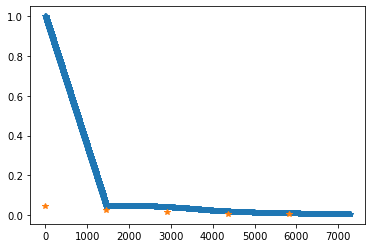

In [103]:
p1,p2 = train_network(nr_of_parameters, 10, nr_of_hidden_neurons, learning_rate, 5, input_train, output_train, input_vali, output_vali) 

## Function to test the network
This function is being used to compare the error (which is being calculated based on the testing dataset) of predicting the output of the network to the real values of the label of certain piece of dataset. The function get as an arguments the parameters of the nodes "parameters1", "parameters2" to recreate the network, and the validation dataset "test_input" with validation labeles "test_output".

In [104]:
def test_network(parameters1, parameters2, test_input, test_output):
    labels = []
    predictions =[]
    for test_idx, input_array in enumerate(test_input):
        hidden_stimulation = np.matmul(parameters1,input_array)
        hidden_output = [activation(x) for x in (hidden_stimulation)]
        output_stimulation = np.matmul(parameters2, hidden_output)
        output = [activation(x) for x in (output_stimulation)]
        
        labels.append(test_output[test_idx])
        predictions.append(np.argmax(output))
        error = np.mean(0.5*(np.subtract(test_output[test_idx], output)**2)/len(test_input))
    return labels, predictions
    
    
    

## Implementation of the testing of the network

In [105]:
labels, predictions = test_network(p1,p2, input_test, output_test)

## Creating the Confusion Matrix
The confusion matrix neatly represent which element sould have been predicted from the testing dataset, and which element was actually predicted.

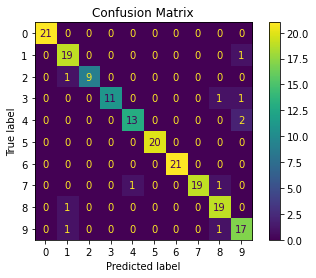

In [106]:
matrix = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()